## Q2: Conduct a customer segmentation for the wholesale distributor dataset.

* Student ID: p233340 
* Name: Kwok Tsz Yi
* Course: COM6101 

In [50]:
# import dataset
import pandas as pd
df = pd.read_csv('Q2.csv')
df.head()

,CustID,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,online,Shenzhen,12669,9656,7561,214,2674.0,1338
1,2,online,Shenzhen,7057,9810,9568,1762,3293.0,1776
2,3,online,Shenzhen,6353,8808,7684,2405,3516.0,7844
3,4,offline,Shenzhen,13265,1196,4221,6404,507.0,1788
4,5,online,Shenzhen,22615,5410,7198,3915,1777.0,5185


### Exploratory Data Analysis

Size of the dataset:

In [51]:
df.shape

(440, 9)

Data types of the dataset:

In [52]:
df.dtypes

CustID                int64
Channel              object
Region               object
Fresh                object
Milk                  int64
Grocery               int64
Frozen                int64
Detergents_Paper    float64
Delicatessen          int64
dtype: object

Missing values in the dataset:

In [53]:
# find rows with missing values
df.isnull().sum()

CustID              0
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    1
Delicatessen        0
dtype: int64

Handle the only missing value in the dataset: fill in the Detergents_Paper NaN with median value.

In [54]:
median_detergents_paper = df['Detergents_Paper'].median()
df['Detergents_Paper'] = df['Detergents_Paper'].fillna(median_detergents_paper)
df.isnull().sum() # check if the missing values are filled

CustID              0
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

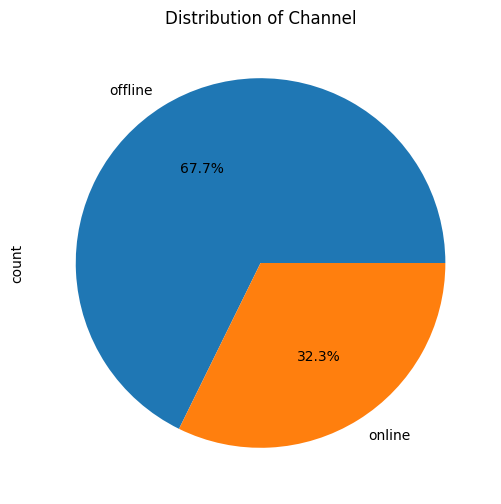

In [55]:
# pie chart for the distribution of the channel
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df['Channel'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Channel')
plt.show()

Most customers purchase from the offline channel, with only about 30% of the customers purchasing from the online channel.

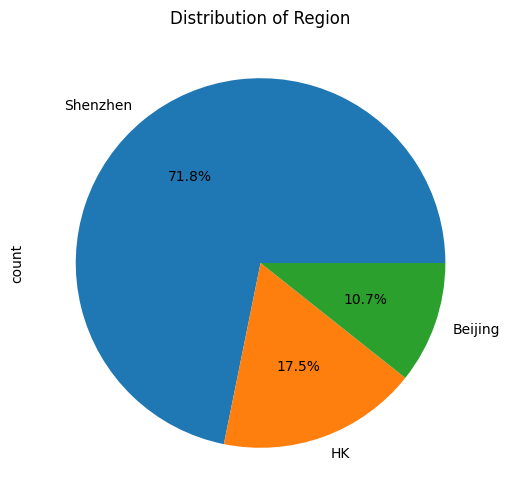

In [56]:
# pie chart for the distribution of the region
plt.figure(figsize=(10, 6))
df['Region'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Region')
plt.show()

For the regional distribution, the majority of the customers are from Shenzen, followed by Hong Kong and Beijing.

In [57]:
# generate a table group by region and find the mean of each product
df.groupby('Region').mean(numeric_only=True)

,CustID,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Region,,,,,,
Beijing,317.000000,5088.170213,9218.595745,4045.361702,3687.468085,1159.702128
HK,235.000000,5486.415584,7403.077922,3000.337662,2651.116883,1354.896104
Shenzhen,202.613924,35021.085443,156932.091772,5286.132911,13387.240506,1968.667722


In [58]:
# generate a table, group by region, sub-group by channel, and find the mean of each product
df.groupby(['Region', 'Channel']).mean(numeric_only=True)

CustID          Milk        Grocery       Frozen  \
Region   Channel                                                         
Beijing  offline  321.000000   2304.250000    4395.500000  5745.035714   
         online   311.105263   9190.789474   16326.315789  1540.578947   
HK       offline  237.728814   3870.203390    4026.135593  3127.322034   
         online   226.055556  10784.000000   18471.944444  2584.111111   
Shenzhen offline  227.582938  46984.156398  227087.161137  7163.658768   
         online   152.438095  10981.009524   15953.809524  1513.200000   

                  Detergents_Paper  Delicatessen  
Region   Channel                                  
Beijing  offline        482.714286   1105.892857  
         online        8410.263158   1239.000000  
HK       offline        950.525424   1197.152542  
         online        8225.277778   1871.944444  
Shenzhen offline      16615.867299   2039.559242  
         online        6899.238095   1826.209524

In [59]:
# generate a table, group by channel, sub-group by region, and find the mean of each product
df.groupby(['Channel', 'Region']).mean(numeric_only=True)

CustID          Milk        Grocery       Frozen  \
Channel Region                                                           
offline Beijing   321.000000   2304.250000    4395.500000  5745.035714   
        HK        237.728814   3870.203390    4026.135593  3127.322034   
        Shenzhen  227.582938  46984.156398  227087.161137  7163.658768   
online  Beijing   311.105263   9190.789474   16326.315789  1540.578947   
        HK        226.055556  10784.000000   18471.944444  2584.111111   
        Shenzhen  152.438095  10981.009524   15953.809524  1513.200000   

                  Detergents_Paper  Delicatessen  
Channel Region                                    
offline Beijing         482.714286   1105.892857  
        HK              950.525424   1197.152542  
        Shenzhen      16615.867299   2039.559242  
online  Beijing        8410.263158   1239.000000  
        HK             8225.277778   1871.944444  
        Shenzhen       6899.238095   1826.209524

<Axes: xlabel='Region'>

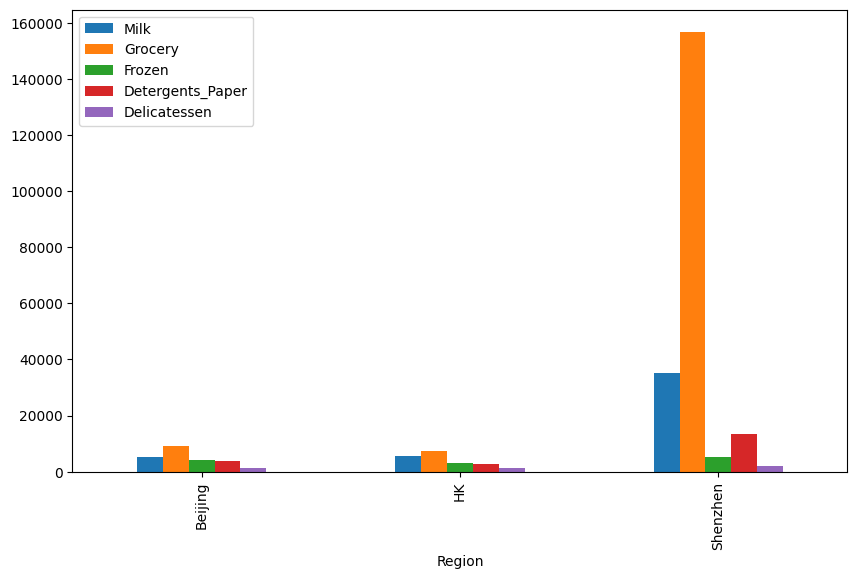

In [60]:
# plot the distribution of the mean sales of each product group by region
df.groupby('Region').mean(numeric_only=True).drop(['CustID'], axis = 1).plot(kind='bar', figsize=(10, 6))

As per the bar chart, there maybe an extreme value in the Grocery Sales of SZ, as the amount of purchase is significantly higher than the rest of the customers.

### Data Preprocessing: Outlier Detection and Removal

In [61]:
# outliers means the data points that are higher than 1.5 IQR or lower than 1.5 IQR
# find outliers in numerical columns
df_1 = df.select_dtypes(include='number').drop(['CustID'], axis=1) # exclude non-numeric columns first
extreme_Q = df_1.quantile(0.99, numeric_only=True)
extreme_value = df_1[(df_1 > extreme_Q)]
extreme_value.count().sum() # there are 7 extreme outliers

25

In [62]:
# find rows in extreme_value with at least one extreme outlier
extreme_value.dropna(how='all')

,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,NaN,NaN,NaN,NaN,16523.0
47,54259.0,55571.0,NaN,NaN,NaN
61,NaN,59598.0,NaN,26701.0,NaN
65,NaN,NaN,NaN,24231.0,NaN
71,NaN,NaN,NaN,NaN,14472.0
85,46197.0,92780.0,NaN,40827.0,NaN
86,73498.0,NaN,NaN,NaN,NaN
87,NaN,NaN,NaN,NaN,14351.0
93,NaN,NaN,35009.0,NaN,NaN
183,43950.0,NaN,36534.0,NaN,47943.0


As per the above analysis, we can see that due to one particular extreme value in the Grocery Sales of SZ, the mean of the Grocery Sales is significantly higher than the median. Therefore, we can consider this as an outlier and remove it from the dataset.

In [63]:
# set the maximum value to the 99th percentile
df_1 = df_1.apply(lambda x: x.clip(upper=x.quantile(0.95)))
extreme_Q = df_1.quantile(0.94, numeric_only=True)
extreme_value = df_1[(df_1 > extreme_Q)]
# apply the clip function to the original dataframe
df[df_1.columns] = df_1
# check if in the original dataframe, the maximum value of each column is the 99th percentile
df[df_1.columns].max()

Milk                18006.60
Grocery             24711.25
Frozen              10009.65
Detergents_Paper    12227.50
Delicatessen         4636.15
dtype: float64

<Axes: xlabel='Region'>

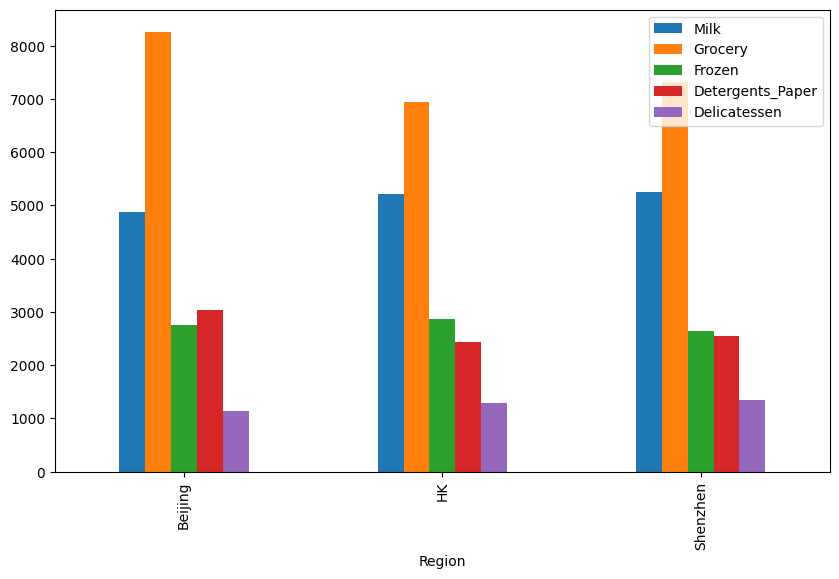

In [64]:
# bar plot for the distribution of the mean sales of each product after processing the extreme outliers
df.groupby('Region').mean(numeric_only=True).drop(['CustID'], axis=1).plot(kind='bar', figsize=(10, 6))

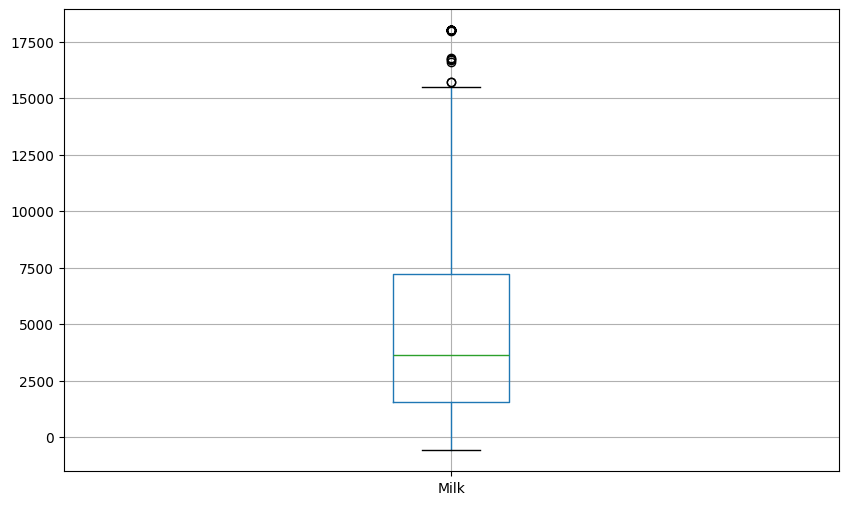

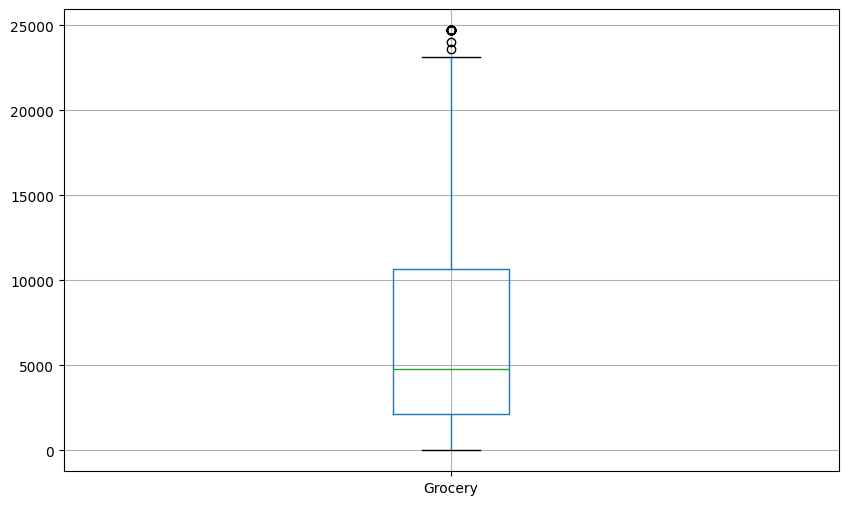

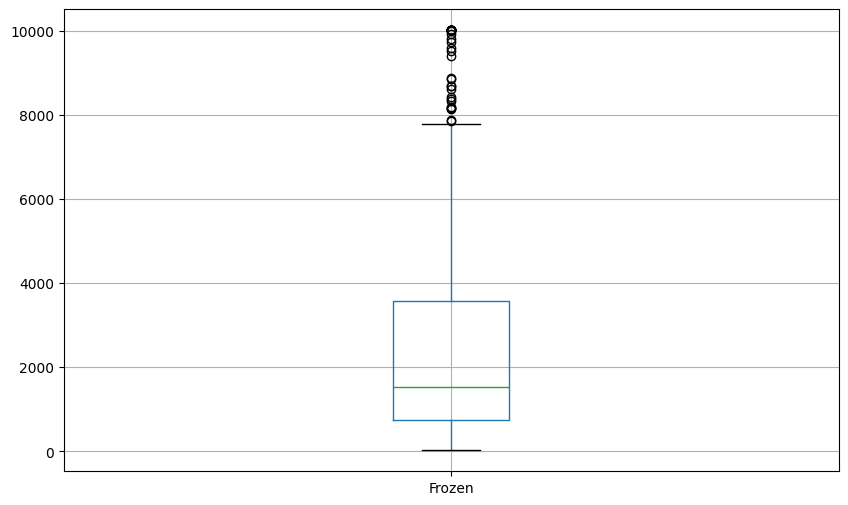

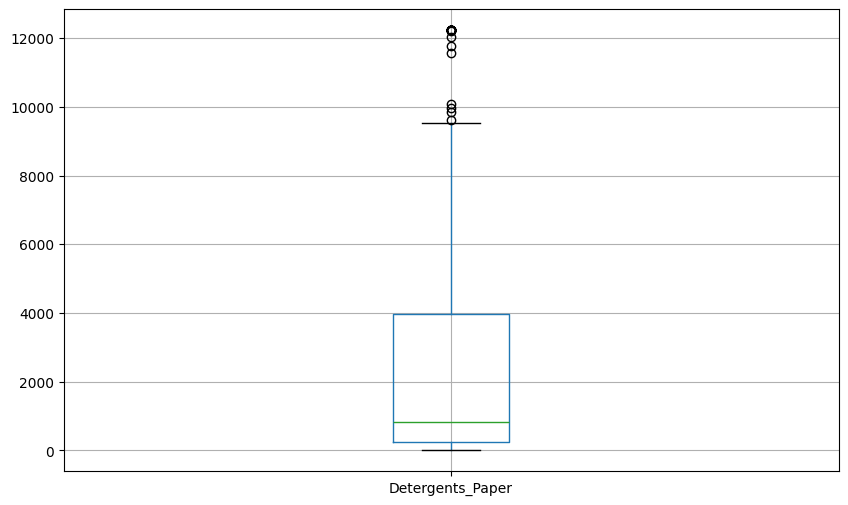

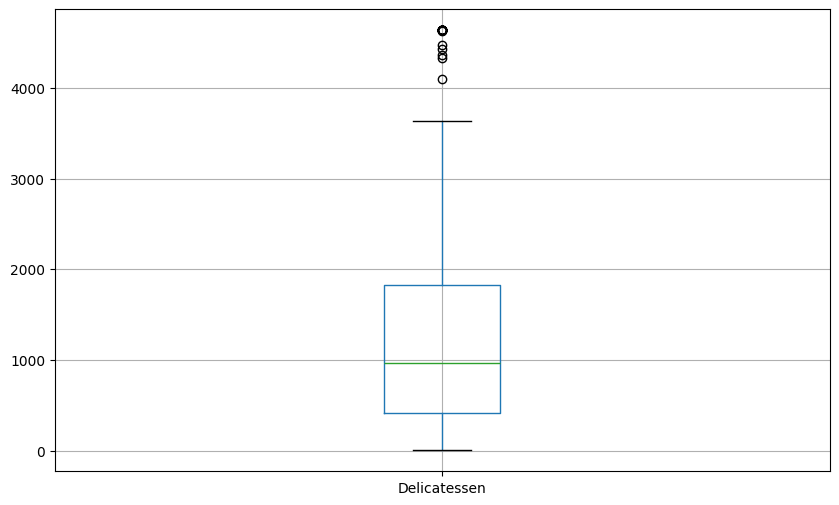

In [65]:
# observe the data distribution with boxplot
df_1 = df.select_dtypes(include='number').drop(['CustID'], axis=1)
for i in df_1.columns:
    plt.figure(figsize=(10, 6))
    df_1.boxplot(column=i)
    plt.show()

### Clustering Analysis

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')

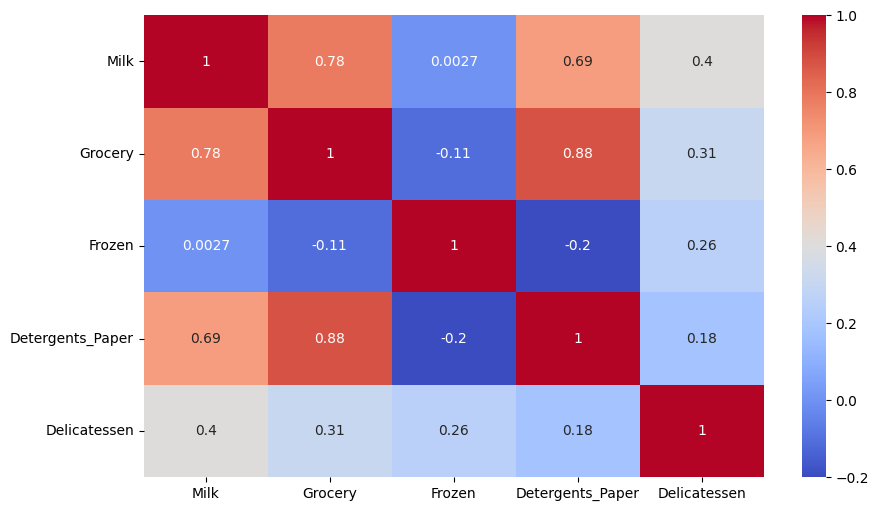

In [67]:
import seaborn as sns
# take a look at the correlation heatmap first, exclude the non-numeric columns and the CustID
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop('CustID', axis=1).corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

Text(0, 0.5, 'WCSS')

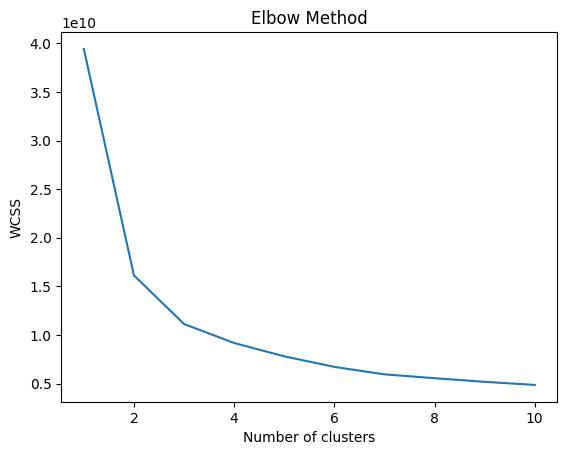

In [68]:
# use the elbow method to find the optimal number of clusters
X = df.select_dtypes(include='number').drop(['CustID'], axis=1)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

As per the Elbow Method, the optimal number of clusters is 3. We will use KMeans clustering to segment the customers into 3 clusters.

In [69]:
# fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)

# add the cluster column to the original dataframe
df['Cluster'] = y_kmeans
df.head()

,CustID,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Cluster
0,1,online,Shenzhen,12669,9656.0,7561.0,214.0,2674.0,1338.00,1
1,2,online,Shenzhen,7057,9810.0,9568.0,1762.0,3293.0,1776.00,1
2,3,online,Shenzhen,6353,8808.0,7684.0,2405.0,3516.0,4636.15,1
3,4,offline,Shenzhen,13265,1196.0,4221.0,6404.0,507.0,1788.00,0
4,5,online,Shenzhen,22615,5410.0,7198.0,3915.0,1777.0,4636.15,1


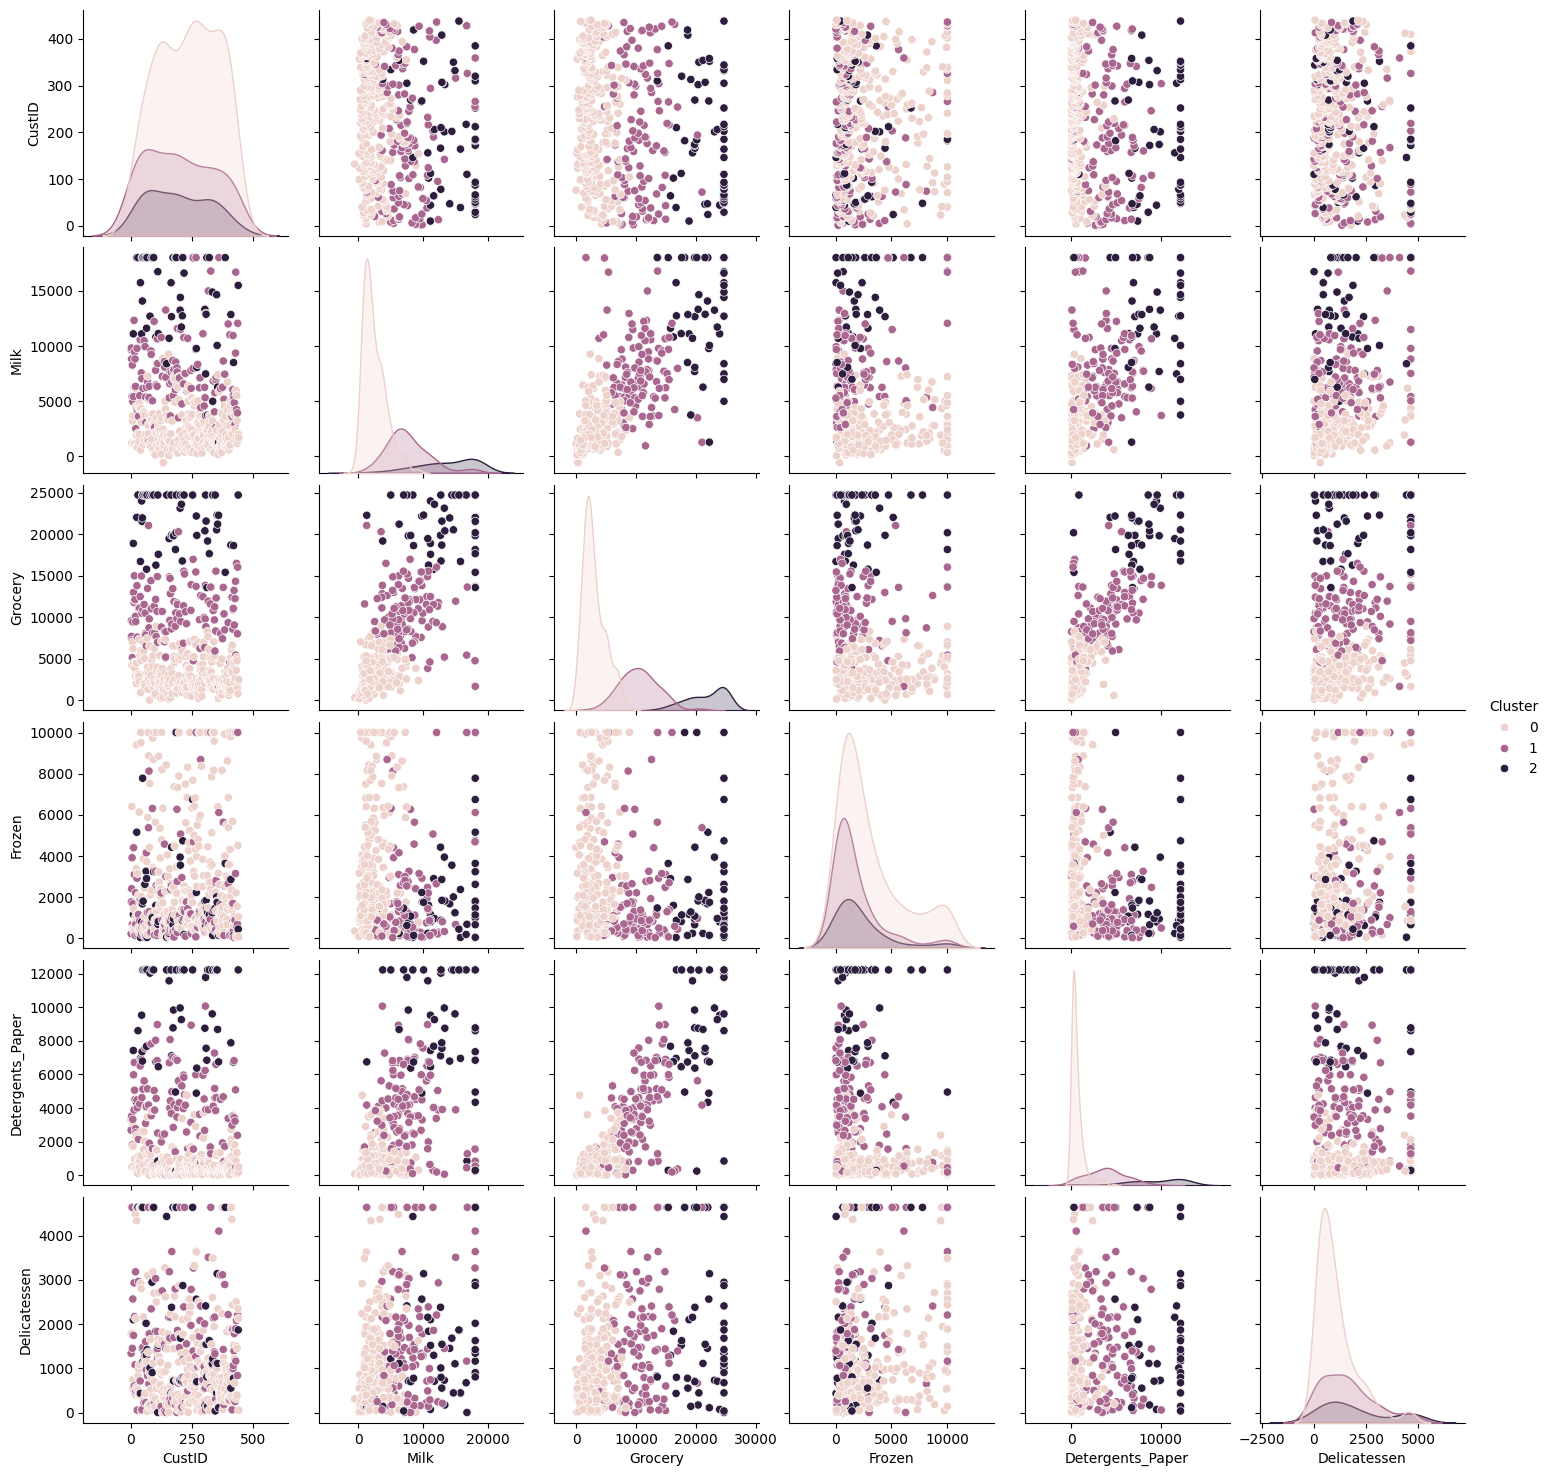

In [70]:
# plot a pairplot to visualize the clusters
import seaborn as sns
sns.pairplot(df, hue='Cluster')

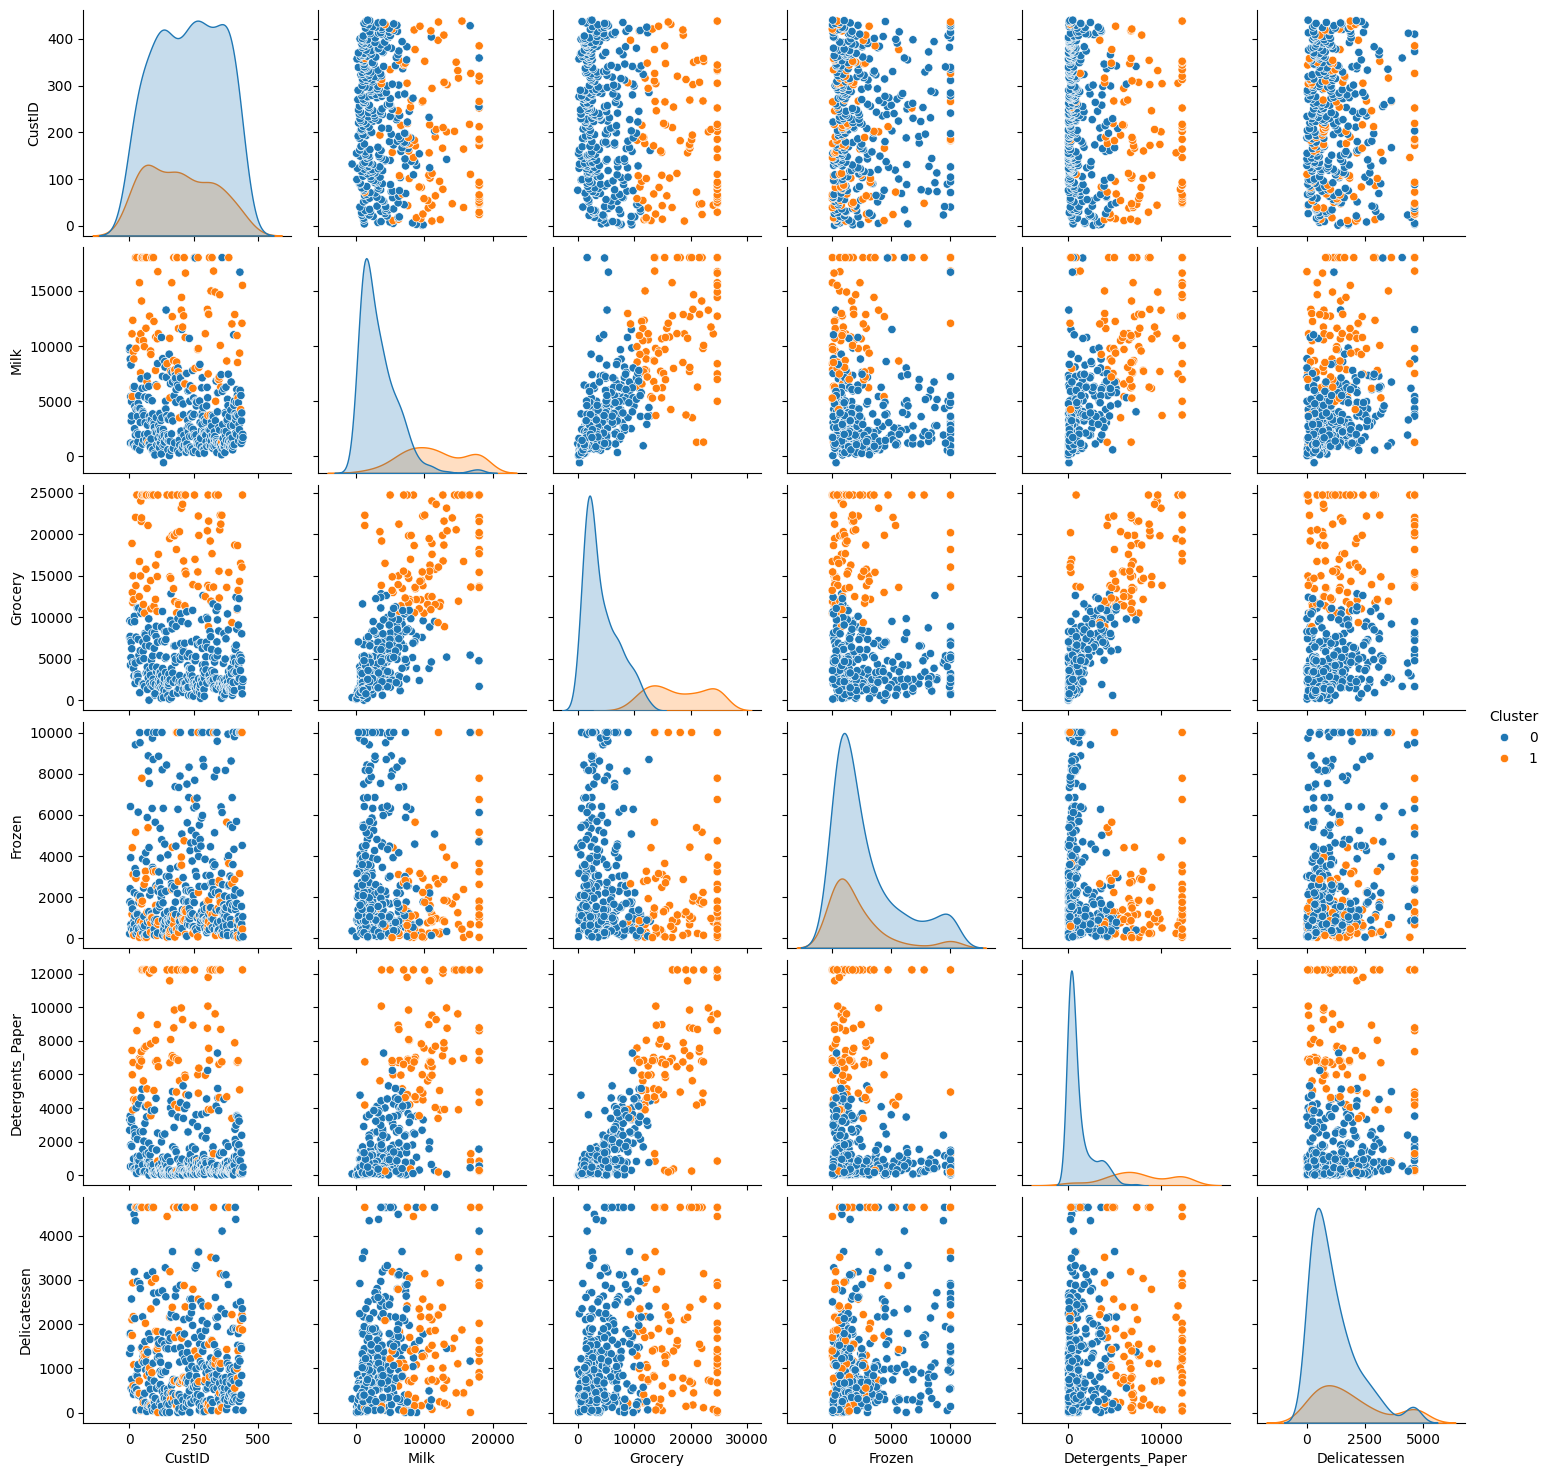

In [71]:
# Try to use 2 clusters instead
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
df['Cluster'] = y_kmeans
sns.pairplot(df, hue='Cluster')